In [9]:
import os
import sys
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

# Assuming the notebook is in 'notebooks/' and the project root is one level up
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify the path has been added (optional)
print(f"Project root added to sys.path: {project_root}")

Project root added to sys.path: d:\Projects\EDA-Clustering-Time-series---Regression-Model-Airbnb-Data


In [4]:
from database import get_sqlalchemy_engine
engine = get_sqlalchemy_engine()

✅ Successfully connected to SQL Server via pyodbc.
✅ SQLAlchemy engine created successfully.


✅ Loaded 1178740 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178740 entries, 0 to 1178739
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   listing_id              1178740 non-null  int64  
 1   total_weeks             1178740 non-null  int64  
 2   offline_weeks           1178740 non-null  int64  
 3   pct_offline_weeks       1178740 non-null  float64
 4   mean_availability       1178740 non-null  float64
 5   first_week              1178740 non-null  object 
 6   last_week               1178740 non-null  object 
 7   base_price              996981 non-null   float64
 8   number_of_reviews       1178740 non-null  int64  
 9   property_city           1178740 non-null  object 
 10  property_country        1178740 non-null  object 
 11  property_neighbourhood  1178740 non-null  object 
 12  latitude                1178740 non-null  float64
 13  longitude               1178740 no

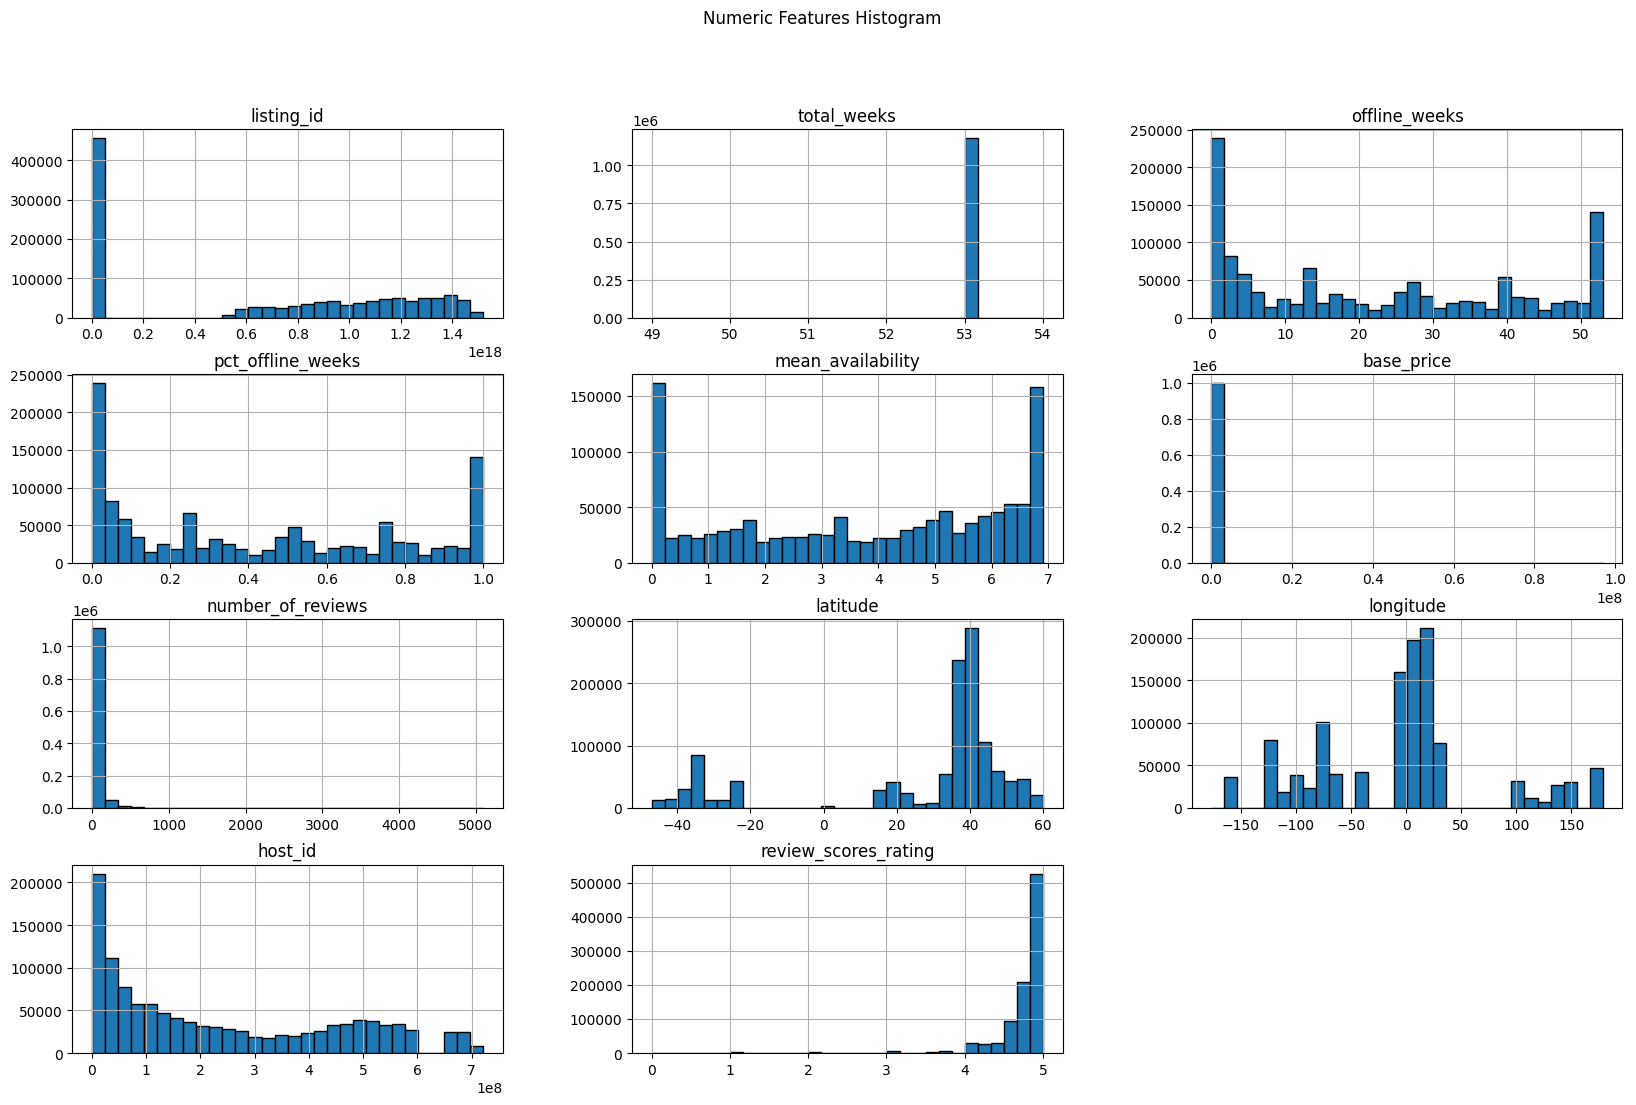

In [5]:
# Load full table
query = "SELECT * FROM listing_features"
df = pd.read_sql(query, engine)

print(f"✅ Loaded {len(df)} rows.")
print(df.info())
print(df.describe(include='all'))

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Numeric distributions
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("\nNumeric feature distributions:")
df[numeric_cols].hist(figsize=(20, 12), bins=30, edgecolor='k')
plt.suptitle("Numeric Features Histogram")
plt.show()

In [6]:
# Filter dataset
df_filtered = df[
    (df['base_price'].notna()) &          # base_price is not null
    (df['base_price'] > 0) &             # base_price > 0
    (df['pct_offline_weeks'] < 1)        # not offline 100% of the year
].copy()

print(f"✅ Filtered dataset: {len(df_filtered)} rows remaining.")
print(df_filtered[['listing_id', 'base_price', 'pct_offline_weeks']].head())

✅ Filtered dataset: 986250 rows remaining.
   listing_id  base_price  pct_offline_weeks
0         360       139.0           0.622642
1         364       179.0           0.018868
2         592        68.0           0.301887
3         686        42.0           0.622642
4         958       157.0           0.188679


In [11]:


print(f"✅ Loaded {len(df_filtered)} rows.")
print(df_filtered.info())
print(df_filtered.describe(include='all'))

✅ Loaded 986250 rows.
<class 'pandas.core.frame.DataFrame'>
Index: 986250 entries, 0 to 1178738
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              986250 non-null  int64         
 1   total_weeks             986250 non-null  int64         
 2   offline_weeks           986250 non-null  int64         
 3   pct_offline_weeks       986250 non-null  float64       
 4   mean_availability       986250 non-null  float64       
 5   first_week              986250 non-null  datetime64[ns]
 6   last_week               986250 non-null  datetime64[ns]
 7   base_price              986250 non-null  float64       
 8   number_of_reviews       986250 non-null  int64         
 9   property_city           986250 non-null  object        
 10  property_country        986250 non-null  object        
 11  property_neighbourhood  986250 non-null  object        
 12  latitude    

In [12]:
# Top 20 highest prices
top_prices = df_filtered[['listing_id', 'property_city', 'base_price']].sort_values(by='base_price', ascending=False).head(20)
print("🔥 Top 20 extreme prices:")
display(top_prices)


🔥 Top 20 extreme prices:


,listing_id,property_city,base_price
689678,939166695586608420,Santiago,96927884.0
472833,585611679710850418,Buenos Aires,63013022.0
873527,1171835238649898320,Buenos Aires,61920797.0
873476,1171797727387603815,Buenos Aires,61920797.0
627599,863708705635094490,Buenos Aires,60012405.0
514227,663791921269219889,Buenos Aires,52773406.0
514226,663791437064459738,Buenos Aires,52773406.0
83767,12103264,Buenos Aires,52773406.0
102385,14228810,Buenos Aires,52773406.0
753822,1031975482740498353,Buenos Aires,47259767.0


In [13]:
# Bottom 20 lowest non-zero prices
bottom_prices = df_filtered[df_filtered['base_price'] > 0][['listing_id', 'property_city', 'base_price']].sort_values(by='base_price').head(20)
print("❄️ Bottom 20 extreme prices:")
display(bottom_prices)


❄️ Bottom 20 extreme prices:


,listing_id,property_city,base_price
324308,41406564,Singapore,1.0
788451,1078964503783527839,Madrid,1.0
953785,1259371487610970172,Puglia,2.0
1171511,1491347288120789351,Clark County,3.0
707019,962702059998563738,Taipei,5.0
707022,962708449640986686,Taipei,5.0
997295,1307078011285176782,Taipei,5.0
719480,981443881050069230,Taipei,5.0
216615,27716513,Berlin,5.0
620387,854126526077679617,Taipei,5.0


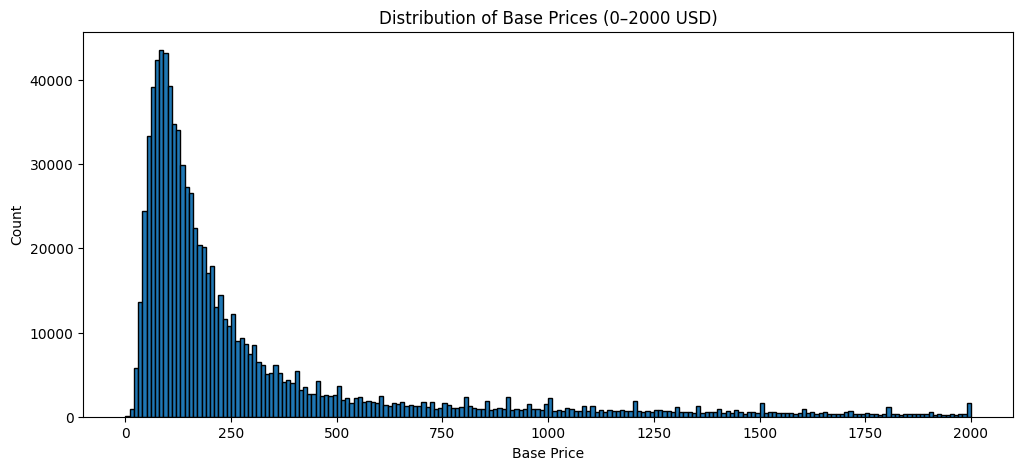

In [14]:


plt.figure(figsize=(12,5))
plt.hist(df_filtered['base_price'], bins=200, range=(0, 2000), edgecolor='k')  # focus on main range
plt.title("Distribution of Base Prices (0–2000 USD)")
plt.xlabel("Base Price")
plt.ylabel("Count")
plt.show()


In [15]:
# Count listings below 1000 USD
below_1000 = (df_filtered['base_price'] < 1000).sum()

# Total listings
total_listings = len(df_filtered)

# Percentage
percentage_below_1000 = (below_1000 / total_listings) * 100

print(f"💰 Listings below $1,000: {below_1000} / {total_listings} ({percentage_below_1000:.2f}%)")


💰 Listings below $1,000: 792145 / 986250 (80.32%)


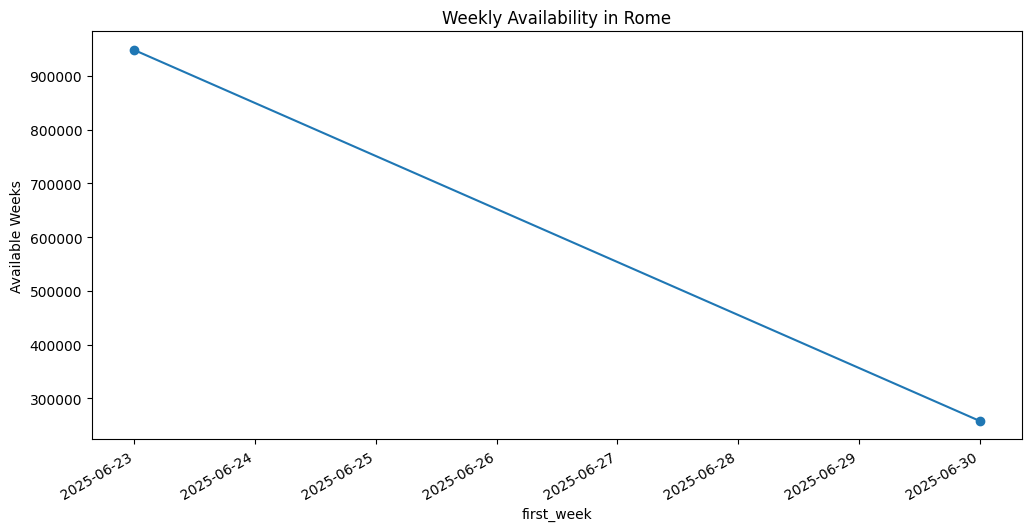

In [7]:
# Convert first_week and last_week to datetime
df_filtered['first_week'] = pd.to_datetime(df_filtered['first_week'])
df_filtered['last_week'] = pd.to_datetime(df_filtered['last_week'])

# Example: aggregate availability per week for a city
df_filtered['available_weeks'] = df_filtered['total_weeks'] - df_filtered['offline_weeks']

city = 'Rome'
city_df = df_filtered[df_filtered['property_city'] == city]

weekly_availability = city_df.groupby('first_week')['available_weeks'].sum().sort_index()
weekly_availability.plot(figsize=(12,6), marker='o')
plt.title(f"Weekly Availability in {city}")
plt.ylabel("Available Weeks")
plt.show()


In [10]:
# Select features
X = df_filtered[['mean_availability', 'pct_offline_weeks', 'number_of_reviews', 'property_city']]
y = df_filtered['base_price']

# Encode categorical feature
X = pd.get_dummies(X, columns=['property_city'], drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit regression
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predictions
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 91551371072.43
